In [1]:
import time, joblib, os, math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from utils.dataset import load_dataset_v2, create_lstm_dataset
from tqdm.notebook import tqdm

In [2]:
file_name_list = os.listdir(os.path.join('data', 'ver_2'))
file_path_list = []

for file_name in file_name_list:
    file_path_list.append(os.path.join('data', 'ver_2', file_name))

start_time = time.strftime('%Y%m%d-%H%M%S', time.localtime(time.time()))

In [3]:
dataset= load_dataset_v2(file_path_list)

loading dataset...:   0%|          | 0/84 [00:00<?, ?it/s]

In [4]:
dataset.shape

(2315250, 18)

In [5]:
dataset = dataset[dataset['outlet_flowrate(lpm)'] > 1]
dataset = dataset[::10]
dataset.reset_index(drop=True, inplace=True)

In [6]:
dataset

time(s)  pressure_1(bar)  main_pressure(bar)  venturi_pressure_1(bar)  \
0         12.25            -0.05                3.01                     3.11   
1         12.35            -0.07                2.92                     3.04   
2         12.45            -0.06                3.08                     3.11   
3         12.55            -0.05                3.04                     3.06   
4         12.65            -0.08                2.83                     3.08   
...         ...              ...                 ...                      ...   
196555   233.62            -0.04               -0.01                     0.03   
196556   233.72            -0.03               -0.06                    -0.01   
196557   233.82            -0.05               -0.11                    -0.01   
196558   233.92            -0.04               -0.01                     0.03   
196559   234.02            -0.03               -0.07                    -0.01   

        venturi_pressure_2(bar)  venturi_pressure_3(bar)  \
0                          0.00                     0.02   
1                          0.02                     0.07   
2                          0.06                     0.12   
3                         -0.01                     0.00   
4                          0.01                     0.07   
...                         ...                      ...   
196555                     0.10                     0.07   
196556                     0.02                     0.04   
196557                     0.08                     0.09   
196558                     0.10                     0.07   
196559                     0.02                     0.05   

        venturi_pressure_4(bar)  venturi_pressure_5(bar)  pump_speed(rpm)  \
0                          0.13                     0.14           609.30   
1                          0.15                     0.23           605.70   
2                          0.14                     0.13           605.03   
3                          0.10                     0.17           608.29   
4                          0.12                     0.23           605.76   
...                         ...                      ...              ...   
196555                     0.03                    -0.05            -0.04   
196556                     0.03                    -0.01            -0.06   
196557                     0.08                    -0.00            -0.02   
196558                     0.03                    -0.03            -0.04   
196559                     0.05                    -0.00            -0.03   

        water_temp(c)  reserved  outlet_flowrate(lpm)  inlet_flowrate(lpm)  \
0               28.47       0.0                  1.63                -3.01   
1               28.46       0.0                  9.34                -2.94   
2               28.49       0.0                 18.83                -2.53   
3               28.50       0.0                 25.48                -2.46   
4               28.50       0.0                 33.20                -2.88   
...               ...       ...                   ...                  ...   
196555          32.27       0.0                 56.37                -2.48   
196556          32.27       0.0                 35.86                -2.11   
196557          32.27       0.0                 16.96                -2.18   
196558          32.27       0.0                 18.22                -2.58   
196559          32.28       0.0                 18.05                -2.70   

        test_case  test_case_iter  nozzle_len(mm)  nozzle_dia(mm)  \
0             1.0             1.0            12.0            12.0   
1             1.0             1.0            12.0            12.0   
2             1.0             1.0            12.0            12.0   
3             1.0             1.0            12.0            12.0   
4             1.0             1.0            12.0            12.0   
...           ...             ...     

In [7]:
extra_column_name_list = ['pressure_1(bar)', 'main_pressure(bar)']
extra_feature = pd.DataFrame()

for col_name in extra_column_name_list:
    extra_feature['grad_'+col_name] = np.gradient(dataset[col_name].to_numpy())

dataset = pd.concat([dataset, extra_feature], axis=1)

In [8]:
dataset_value = dataset.drop(columns=['reserved', 'time(s)', 'test_case', 'test_case_iter'])
dataset_value = pd.concat([dataset_value, extra_feature], axis=1)

<AxesSubplot:>

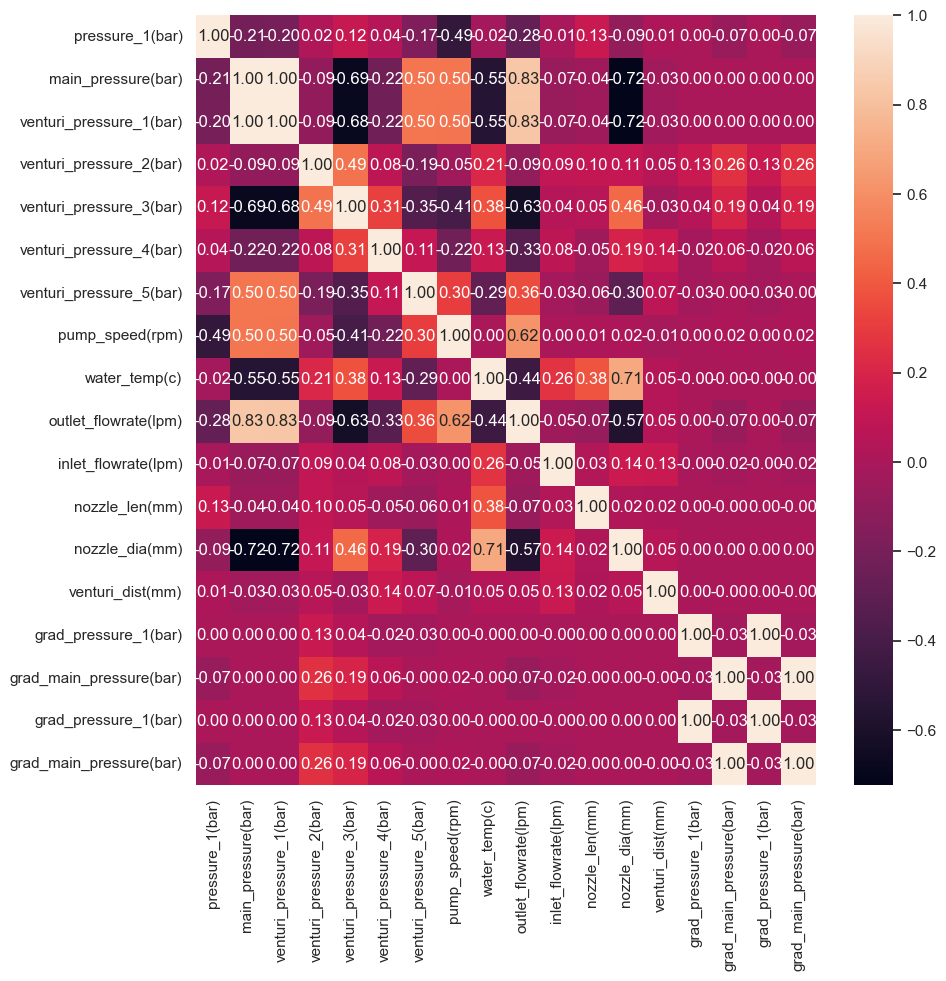

In [9]:
sns.set(font_scale=1.0)
plt.figure(figsize=(10, 10))
sns.heatmap(dataset_value.corr(), annot=True, fmt='.2f')

(-0.5, 0.5)

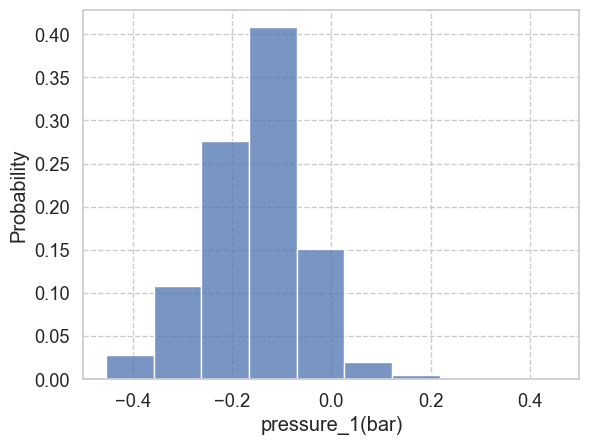

In [10]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil((dataset['pressure_1(bar)'].max()-dataset['pressure_1(bar)'].min())*10)
sns.histplot(dataset['pressure_1(bar)'], stat='probability', bins=n_bin)
#sns.histplot(val_data['pressure_1(bar)'], kde='True')
#plt.legend(title='Dataset Type', labels=['train', 'val'])
plt.xlim(-0.5, 0.5)
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

(-0.5, 0.5)

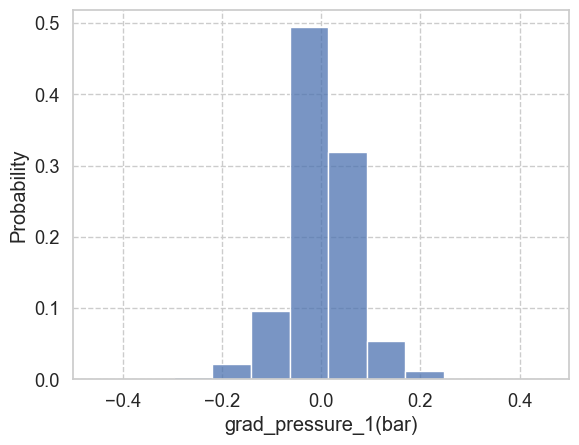

In [11]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil((dataset['grad_pressure_1(bar)'].max()-dataset['pressure_1(bar)'].min())*10)
sns.histplot(dataset['grad_pressure_1(bar)'], stat='probability', bins=n_bin)
#sns.histplot(val_data['pressure_1(bar)'], kde='True')
#plt.legend(title='Dataset Type', labels=['train', 'val'])
plt.xlim(-0.5, 0.5)
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

(0.0, 25.0)

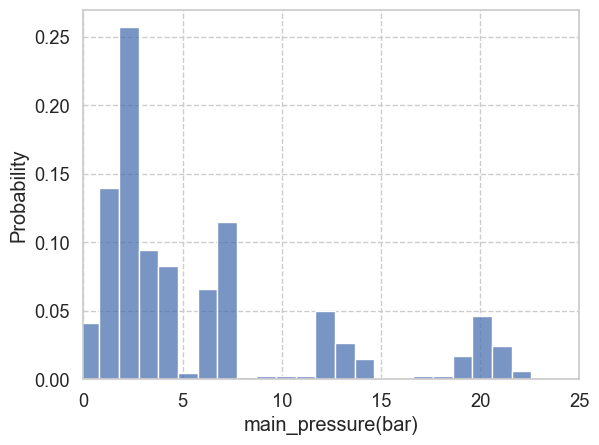

In [12]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil(dataset['main_pressure(bar)'].max()-dataset['main_pressure(bar)'].min())
sns.histplot(dataset['main_pressure(bar)'], stat='probability', bins=n_bin)
#sns.histplot(val_data['main_pressure(bar)'], kde='True')
#plt.legend(title='Dataset Type', labels=['train', 'val'])
plt.xlim(0, 25)
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

(-0.5, 0.5)

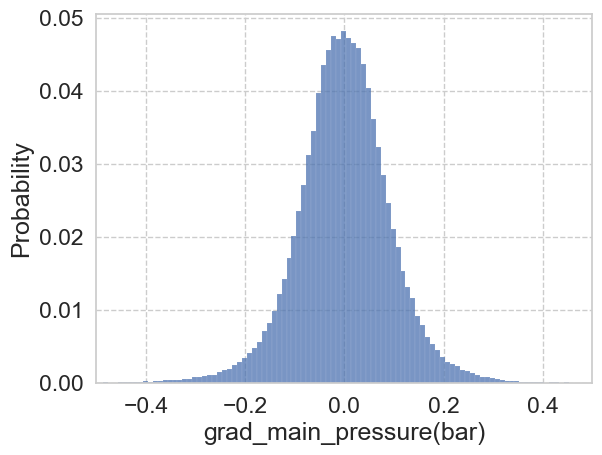

In [13]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil((dataset['grad_main_pressure(bar)'].max()-dataset['grad_main_pressure(bar)'].min())*100)
sns.histplot(dataset['grad_main_pressure(bar)'], stat='probability', common_norm=False, bins=n_bin)
#sns.histplot(val_data['pressure_1(bar)'], kde='True')
#plt.legend(title='Dataset Type', labels=['train', 'val'])
plt.xlim(-0.5, 0.5)
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

(28.0, 33.0)

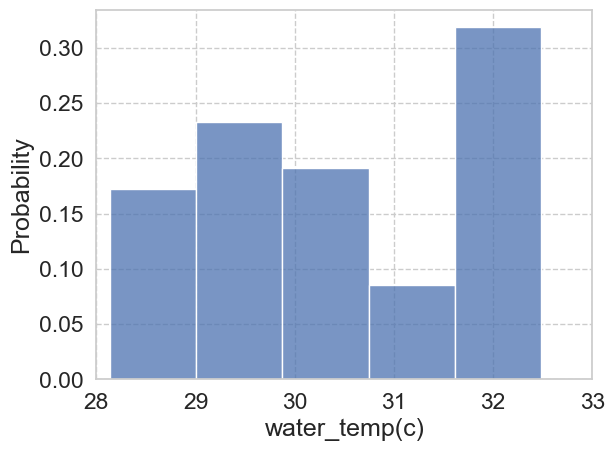

In [14]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil(dataset['water_temp(c)'].max()-dataset['water_temp(c)'].min())
sns.histplot(dataset['water_temp(c)'], stat='probability', bins=n_bin)
plt.xlim(28, 33)
#sns.histplot(val_data['water_temp(c)'], kde='True')
#plt.legend(title='Dataset Type', labels=['train', 'val'])
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

(0.0, 2500.0)

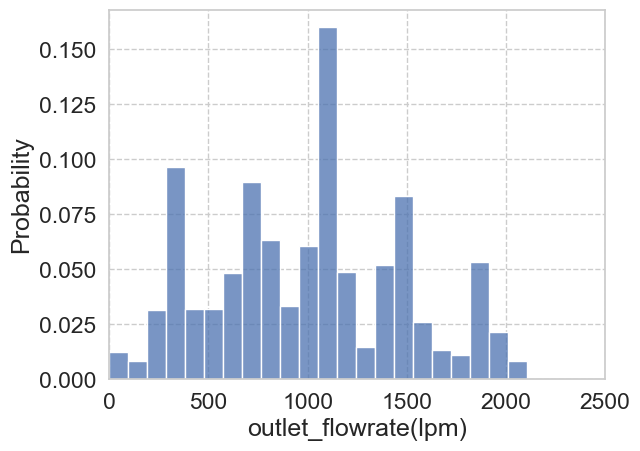

In [15]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil((dataset['outlet_flowrate(lpm)'].max()-dataset['outlet_flowrate(lpm)'].min())/100)
sns.histplot(dataset['outlet_flowrate(lpm)'], stat='probability', bins=n_bin)
plt.xlim(0, 2500)
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

Text(0, 0.5, 'Venturi Pump Outlet Flow-rate(LPM)')

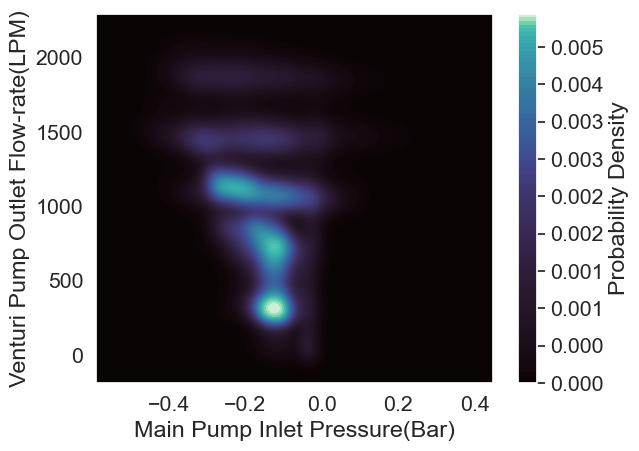

In [26]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(data=dataset, x='pressure_1(bar)', y='outlet_flowrate(lpm)', thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Main Pump Inlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')

(0.0, 2500.0)

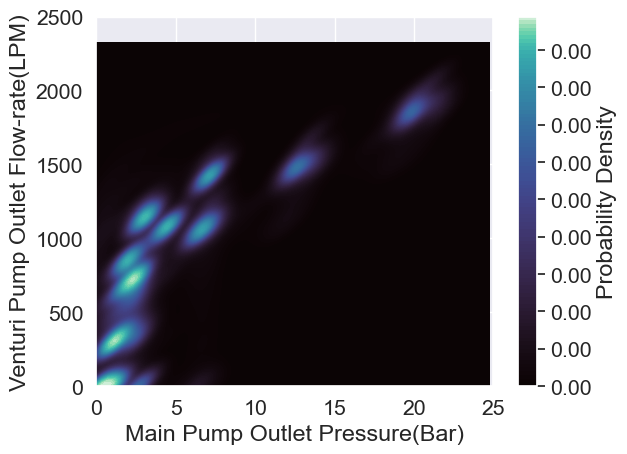

In [22]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(data=dataset, x='main_pressure(bar)', y='outlet_flowrate(lpm)', thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Main Pump Outlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')

Text(0, 0.5, 'Venturi Pump Outlet Flow-rate(LPM)')

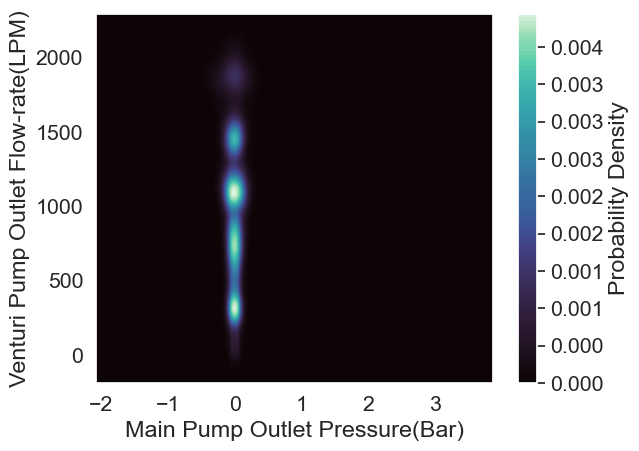

In [43]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(data=dataset, x=np.gradient(dataset['main_pressure(bar)'].to_numpy()), y='outlet_flowrate(lpm)', thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Main Pump of Gradient Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.xlim(-1, 1)

In [75]:
time_arr = dataset['time(s)']
p1 = dataset['main_pressure(bar)'][0:30]
signal_tensor = tf.convert_to_tensor(p1, dtype=tf.float32)
dct_transformed = tf.signal.dct(signal_tensor, type=2)
threshold = tf.reduce_max(tf.abs(dct_transformed)) * 0.1
dct_filtered = tf.where(tf.abs(dct_transformed) < threshold, 0.0, dct_transformed)

<AxesSubplot:ylabel='main_pressure(bar)'>

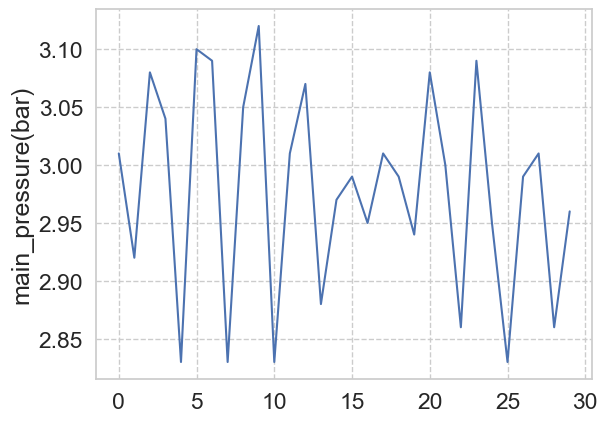

In [76]:
sns.lineplot(p1)

(0.0, 30.0)

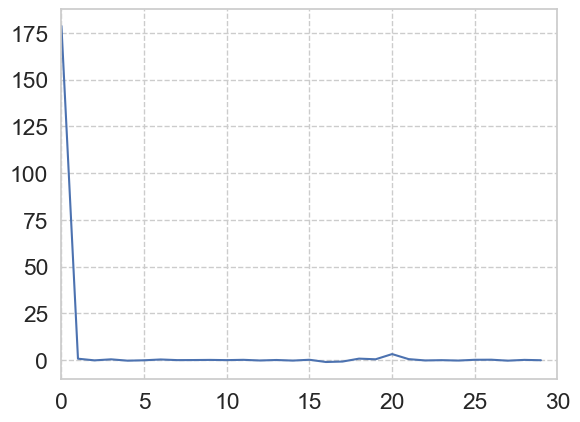

In [77]:
sns.lineplot(dct_transformed)
plt.xlim(0, 30)

In [16]:
feature_col_name_list = ['pressure_1(bar)', 'main_pressure(bar)', 'grad_pressure_1(bar)', 'grad_main_pressure(bar)']
target_col_name = 'outlet_flowrate(lpm)'

train_data = dataset[dataset['test_case_iter']!=3]
val_data = dataset[dataset['test_case_iter']==3]

train_feature = train_data[feature_col_name_list]
train_feature.reset_index(drop=True, inplace=True)

train_target = pd.DataFrame(train_data[target_col_name])
train_target.reset_index(drop=True, inplace=True)

val_feature = val_data[feature_col_name_list]
val_feature.reset_index(drop=True, inplace=True)

val_target = pd.DataFrame(val_data[target_col_name])
val_target.reset_index(drop=True, inplace=True)

In [19]:
print(len(train_data), len(train_feature))

132560 132560


In [44]:
print(len(val_data), len(val_feature))

64000 64000


In [17]:
seq_len = 30
pred_distance = 0
n_feature = len(feature_col_name_list)
n_output = 1
hidden_size = 500

In [18]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, verbose=0)
csv_logger = keras.callbacks.CSVLogger('log.csv', append=True, separator=',')
model_chk_point = keras.callbacks.ModelCheckpoint(filepath='lstm_model.keras', monitor="val_loss", verbose=0, save_best_only=True,
                                                  save_weights_only=False, mode="min", save_freq="epoch", initial_value_threshold=None)

In [19]:
def lstm_est_model():
    freq_time = tf.convert_to_tensor(np.fft.fftfreq(n=30, d=0.1))
    input_tensor = keras.layers.Input(shape=(seq_len, n_feature), dtype=tf.float32)
    input_flatten_layer = keras.layers.Flatten()(input_tensor)

    mean_tensor = tf.reduce_mean(input_tensor, axis=1)
    max_tensor = tf.reduce_max(input_tensor, axis=1)
    min_tensor = tf.reduce_min(input_tensor, axis=1)
    sum_tensor = tf.reduce_sum(input_tensor, axis=1)
    std_tensor = tf.math.reduce_std(input_tensor, axis=1)

    fft_value_tensor = tf.signal.fft(tf.cast(input_tensor, dtype=tf.complex64))
    fft_value_tensor = tf.cast(tf.math.abs(fft_value_tensor), dtype=tf.float32)

    fft_max_time = tf.gather(freq_time, tf.math.argmax(fft_value_tensor, axis=1))
    fft_max_val = tf.math.reduce_max(fft_value_tensor, axis=1)

    avg_low_bool = tf.less(input_tensor, tf.expand_dims(mean_tensor, axis=1))
    avg_low_count = tf.math.count_nonzero(avg_low_bool, axis=1, dtype=tf.float32)
    
    avg_high_count = tf.math.count_nonzero(tf.math.logical_not(avg_low_bool), axis=1, dtype=tf.float32)
    
    feature_eng_tensor = keras.layers.concatenate([mean_tensor, max_tensor, min_tensor, sum_tensor, std_tensor, fft_max_time, fft_max_val, avg_low_count, avg_high_count])

    # Convolutional Layers
    conv_layer = keras.layers.Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(input_tensor)
    
    conv_layer = keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(conv_layer)
    conv_layer = keras.layers.MaxPooling1D(pool_size=2)(conv_layer)
    conv_layer = keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(conv_layer)
    conv_layer = keras.layers.Conv1D(filters=64, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(conv_layer)
    conv_flatten_layer = keras.layers.GlobalAveragePooling1D()(conv_layer)

    # LSTM Layers
    lstm_output_1 = keras.layers.LSTM(units=hidden_size, return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.03), name='lstm_1')(conv_layer)
    lstm_output_2 = keras.layers.LSTM(units=hidden_size, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.03), name='lstm_2')(conv_layer)
    lstm_output_2 = keras.layers.LSTM(units=int(hidden_size/2), return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.03), name='lstm_3')(lstm_output_2)

    # Concatenation of all features
    concat_tensor = keras.layers.concatenate([input_flatten_layer, conv_flatten_layer, lstm_output_1, lstm_output_2, feature_eng_tensor], axis=-1)

    # Output Layer
    output_tensor = keras.layers.Dense(n_output, activation='linear')(concat_tensor)

    # Model Compilation
    model = keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

    return model

In [20]:
lstm_model = lstm_est_model()
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 4)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 24, 64)       1856        ['input_1[0][0]']                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 30, 4)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 20, 128)      41088       ['conv1d[0][0]']                 
                                                                                              

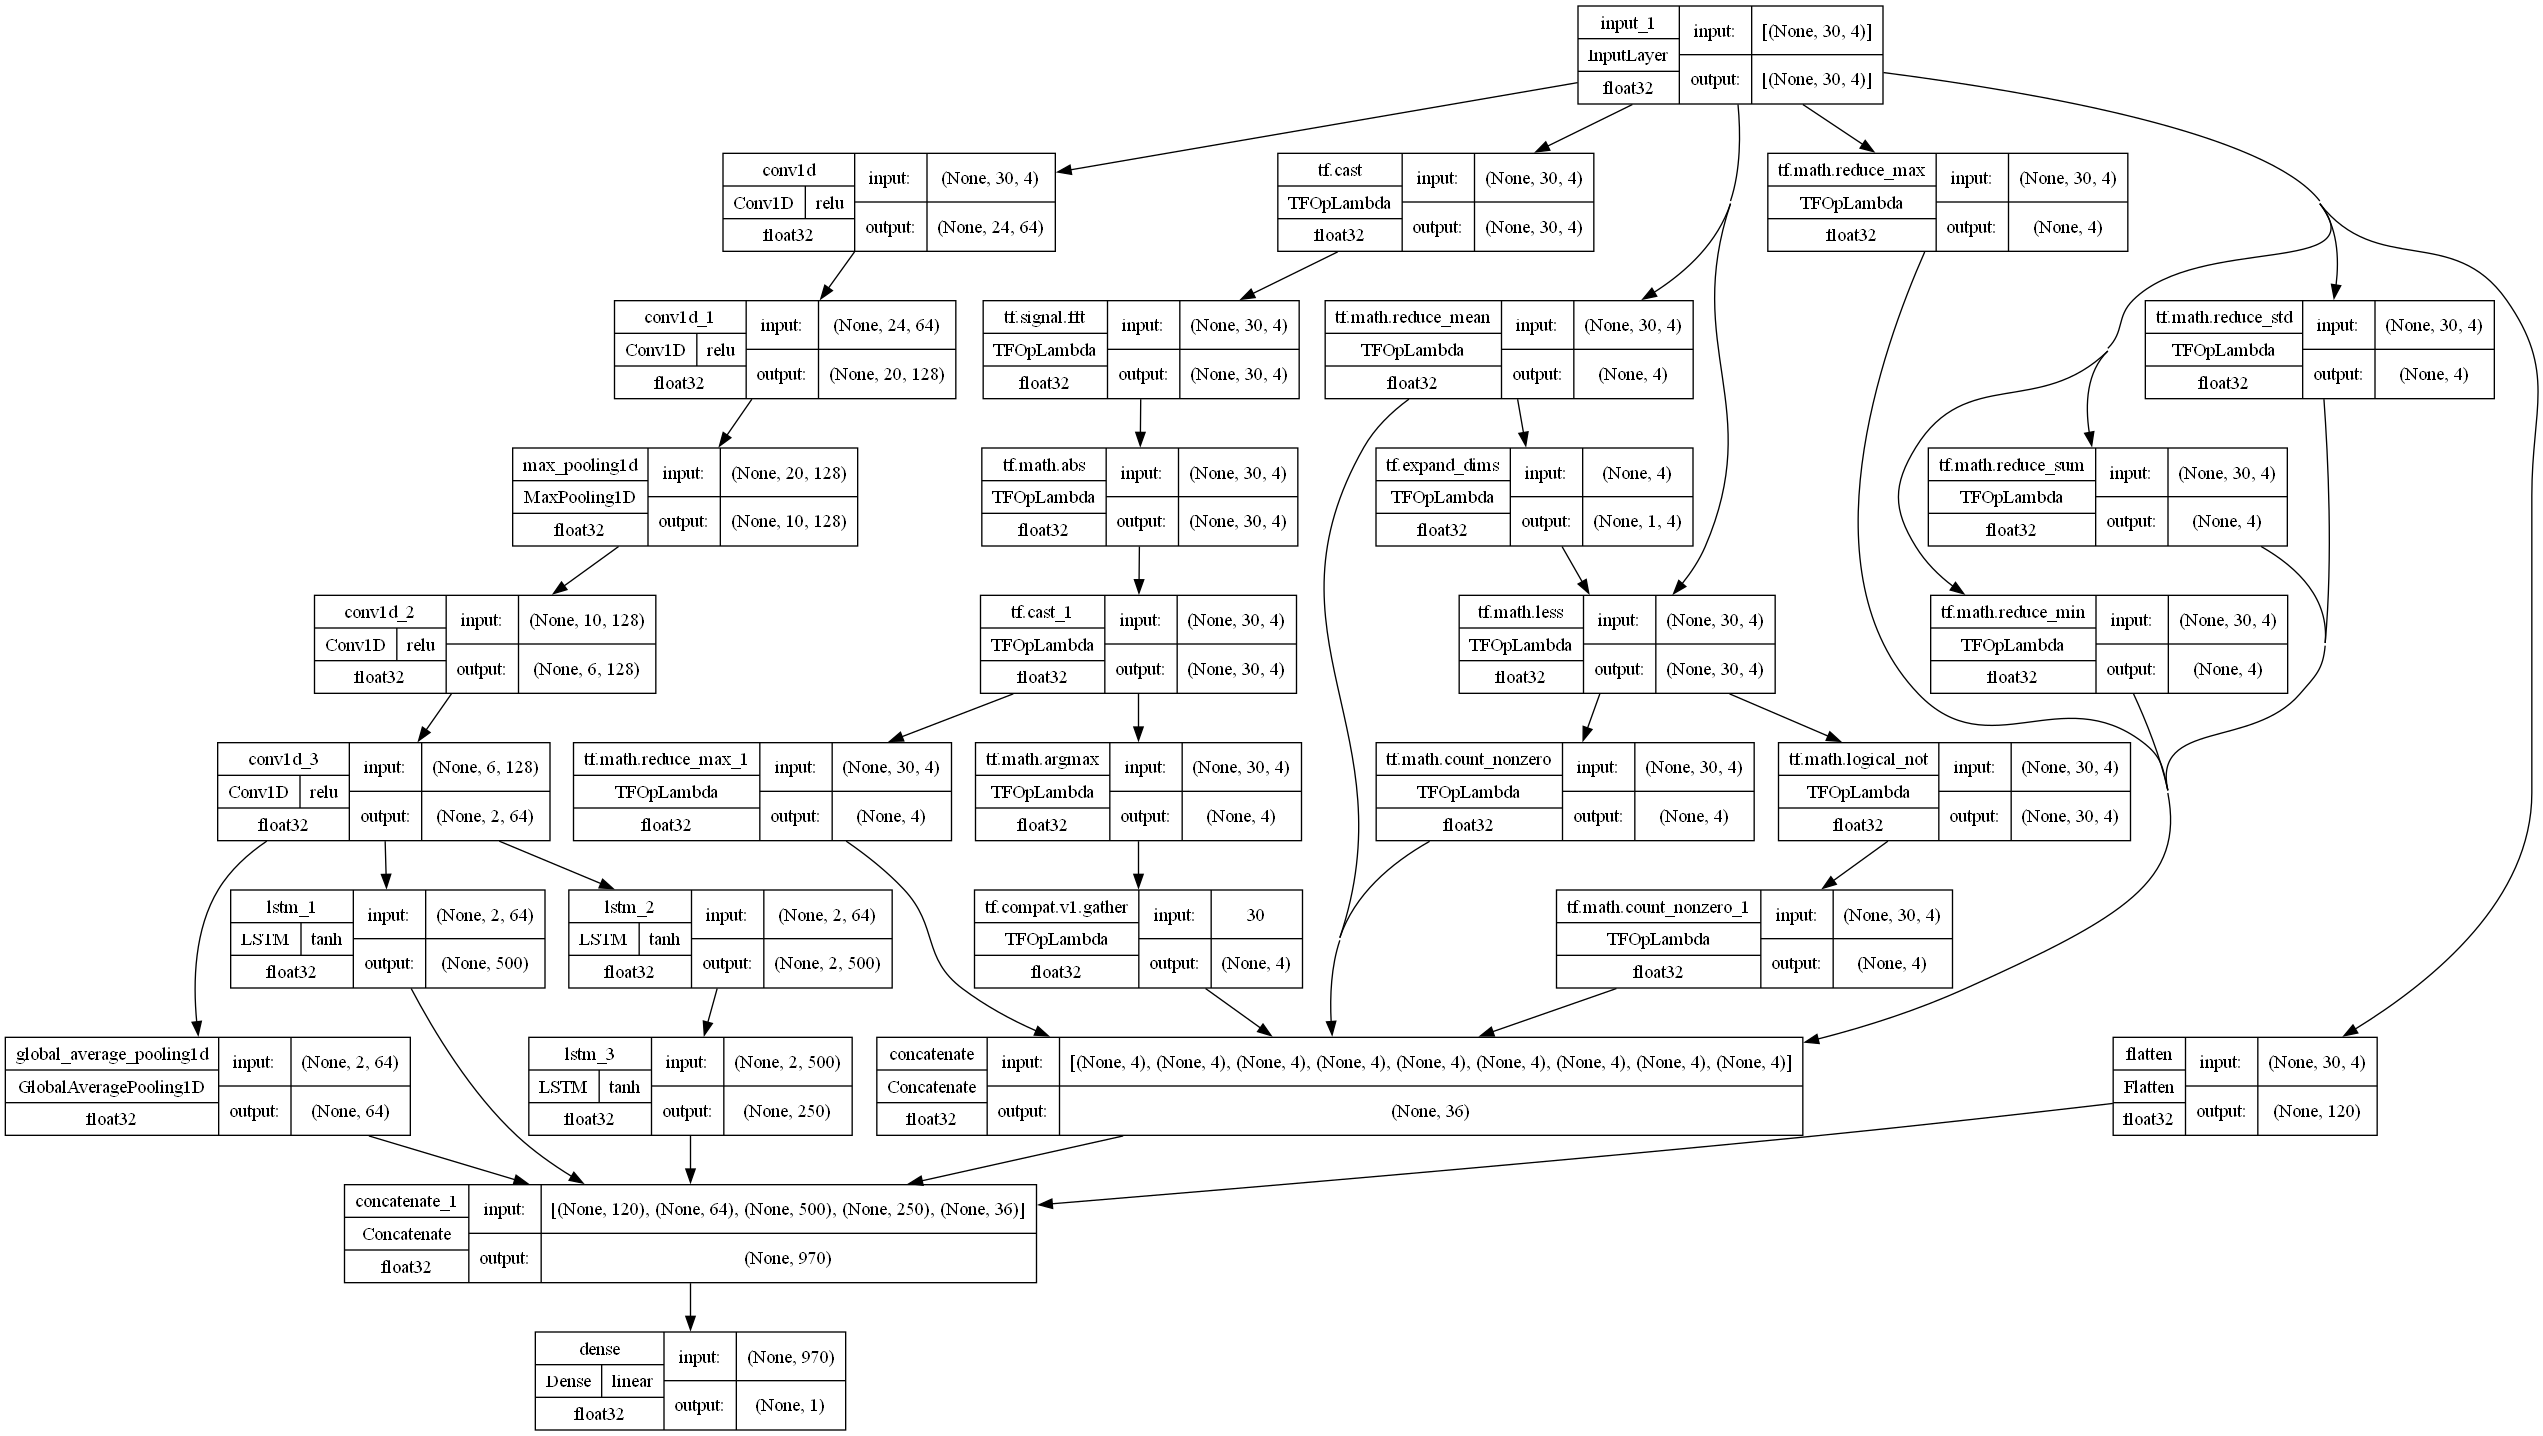

In [21]:
keras.utils.plot_model(lstm_model, to_file='model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [22]:
train_feature, train_target = create_lstm_dataset(train_data[feature_col_name_list+[target_col_name]].to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
val_feature, val_target = create_lstm_dataset(val_data[feature_col_name_list+[target_col_name]].to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)

In [23]:
model_history= lstm_model.fit(x=train_feature, y=train_target, validation_data=(val_feature, val_target), epochs=1000000, 
                              batch_size=10000, verbose=0, callbacks=[early_stop, csv_logger, model_chk_point])

In [24]:
best_lstm_model = keras.models.load_model('lstm_model.keras')

In [25]:
train_pred = np.squeeze(best_lstm_model.predict(train_feature, verbose=1))
val_pred = np.squeeze(best_lstm_model.predict(val_feature, verbose=1))

2000/2000 [==============================] - 51s 25ms/step


In [26]:
print(r2_score(train_target, train_pred), r2_score(val_target, val_pred))

0.9601764233065029 0.9487211008257143


In [28]:
print(mean_absolute_error(train_target, train_pred), mean_absolute_error(val_target, val_pred))

67.39041075689256 76.73968487818179


In [29]:
print(mean_absolute_percentage_error(train_target, train_pred), mean_absolute_percentage_error(val_target, val_pred))

0.19359642090500392 0.2366918279419274


In [ ]:
pd.DataFrame(train_pred, columns=['train_pred']).to_csv('train_pred.csv', index=False)
pd.DataFrame(val_pred, columns=['val_pred']).to_csv('val_pred.csv', index=False)

In [80]:
train_target_list = []
train_target_pred_list = []

train_data_test_case = train_data['test_case'].astype(np.uint8).unique()

for test_case in tqdm(train_data_test_case):
    train_data_sample = train_data[train_data['test_case'] == test_case]
    
    for i in range(int(train_data['test_case_iter'].max())):
        train_data_sample_iter = train_data_sample[train_data_sample['test_case_iter'] == i+1]
        train_data_sample_iter_arr = train_data_sample_iter[feature_col_name_list+[target_col_name]].to_numpy()
        train_feature, train_target = create_lstm_dataset(train_data_sample_iter_arr, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
        
        train_target_list.append(train_target)
        train_target_pred_list.append(np.squeeze(best_lstm_model.predict(train_feature, verbose=0)))

train_r2_score_list = []
train_mean_abs_error_list = []
train_mean_relative_error_list = []

for i in range(len(train_target_list)):
    train_r2_score_list.append(r2_score(train_target_list[i], train_target_pred_list[i]))
    train_mean_abs_error_list.append(mean_absolute_error(train_target_list[i], train_target_pred_list[i]))
    train_mean_relative_error_list.append(np.mean((abs(train_target_list[i]-train_target_pred_list[i])/train_target_list[i])*100))

print(np.mean(train_r2_score_list), np.mean(train_mean_abs_error_list), np.mean(train_mean_relative_error_list))

  0%|          | 0/28 [00:00<?, ?it/s]

0.9390764948943247 63.61264195388388 12.183447952661508


In [81]:
val_target_list = []
val_target_pred_list = []

val_data_test_case = val_data['test_case'].astype(np.uint8).unique()

for test_case in tqdm(val_data_test_case):
    val_data_sample = val_data[val_data['test_case'] == test_case]
    
    val_data_sample_arr = val_data_sample[feature_col_name_list+[target_col_name]].to_numpy()
    val_feature, val_target = create_lstm_dataset(val_data_sample_arr, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
        
    val_target_list.append(val_target)
    val_target_pred_list.append(np.squeeze(best_lstm_model.predict(val_feature, verbose=0)))

val_r2_score_list = []
val_mean_abs_error_list = []
val_mean_relative_error_list = []

for i in range(len(val_target_list)):
    val_r2_score_list.append(r2_score(val_target_list[i], val_target_pred_list[i]))
    val_mean_abs_error_list.append(mean_absolute_error(val_target_list[i], val_target_pred_list[i]))
    val_mean_relative_error_list.append(np.mean((abs(val_target_list[i]-val_target_pred_list[i])/val_target_list[i])*100))
    
print(np.mean(val_r2_score_list), np.mean(val_mean_abs_error_list), np.mean(val_mean_relative_error_list))

  0%|          | 0/28 [00:00<?, ?it/s]

0.9127236449036158 76.34796860868627 15.97248851124773


<AxesSubplot:>

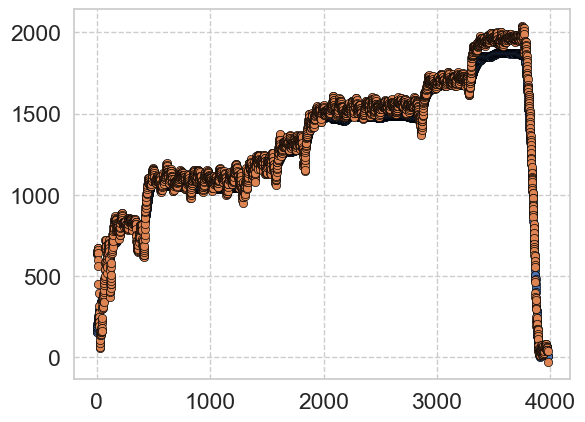

In [82]:
index = 0
time_arr = np.arange(0, len(train_target_list[index]))
sns.scatterplot(x=time_arr, y=train_target_list[index], edgecolor='black')
sns.scatterplot(x=time_arr, y=train_target_pred_list[index], edgecolor='black')

<AxesSubplot:>

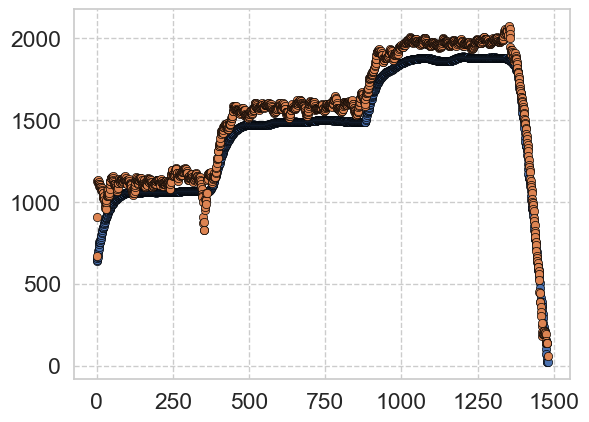

In [115]:
index = 0
time_arr = np.arange(0, len(val_target_list[index]))
sns.scatterplot(x=time_arr, y=val_target_list[index], edgecolor='black')
sns.scatterplot(x=time_arr, y=val_target_pred_list[index], edgecolor='black')

In [30]:
loss_list = model_history.history['loss']
val_loss_list = model_history.history['val_loss']
mean_abs_loss_list = model_history.history['mean_absolute_error']
val_mean_abs_loss_list = model_history.history['val_mean_absolute_error']

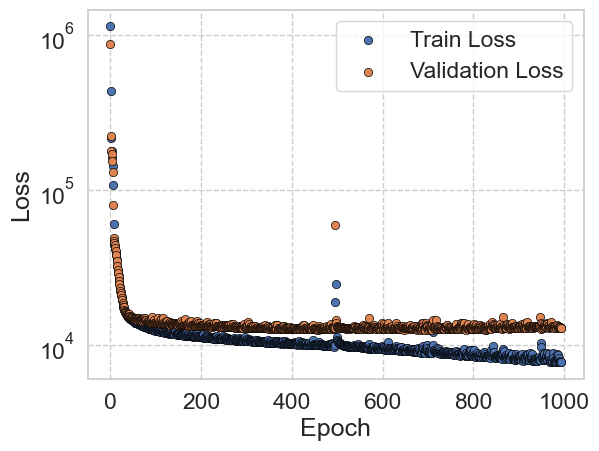

In [31]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.scatterplot(x=np.arange(0, len(loss_list)), y=loss_list, edgecolor='black')
sns.scatterplot(x=np.arange(0, len(val_loss_list)), y=val_loss_list, edgecolor='black')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])

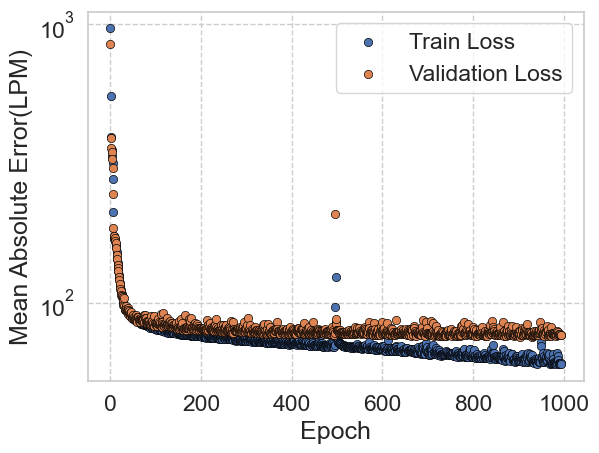

In [32]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.scatterplot(x=np.arange(0, len(mean_abs_loss_list)), y=mean_abs_loss_list, edgecolor='black')
sns.scatterplot(x=np.arange(0, len(val_mean_abs_loss_list)), y=val_mean_abs_loss_list, edgecolor='black')

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error(LPM)')
plt.yscale('log')
plt.legend(['Train Loss', 'Validation Loss'])

In [33]:
relative_error_list = np.array([])
val_target_arr = np.array([])

for i in range(len(val_target_list)):
    val_target_arr = np.concatenate([val_target_arr, val_target_list[i]])
    relative_error_list = np.concatenate([relative_error_list, np.array(abs(val_target_list[i]-val_target_pred_list[i])/val_target_list[i])*100])

NameError: name 'val_target_list' is not defined

<AxesSubplot:xlabel='Venturi Pump Outlet Flow-rate(LPM)', ylabel='Relative Error(%)'>

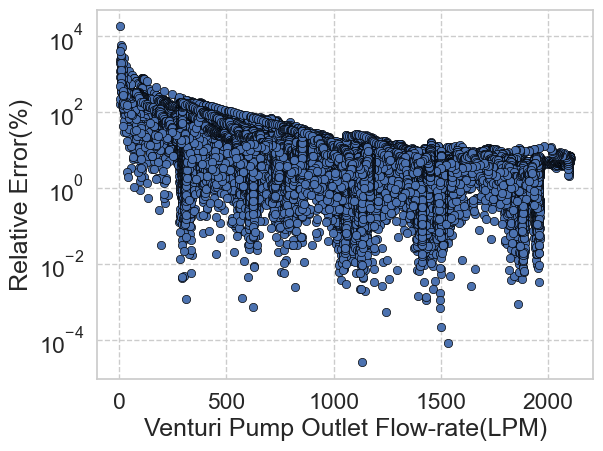

In [101]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
sns.scatterplot(x=val_target_arr, y=relative_error_list, edgecolor='black')

(0.0, 100.0)

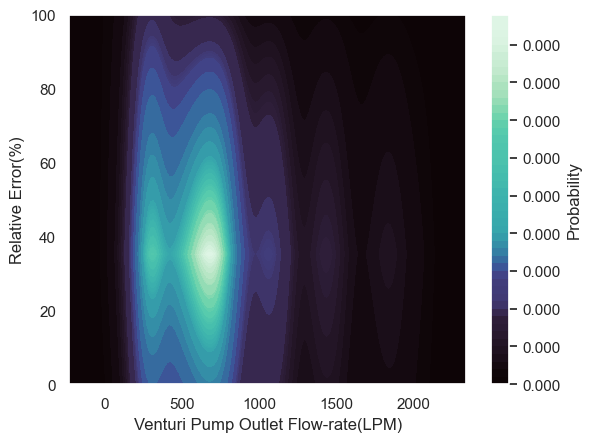

In [99]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')

sns.kdeplot(x=val_target_arr, y=relative_error_list, levels=50, thresh=0, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability', 'format': '%.3f'})

plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
plt.ylim(0, 100)

(0.0, 100.0)

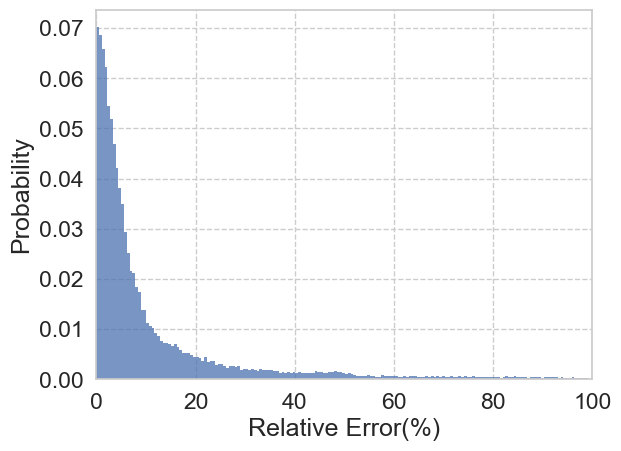

In [102]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
sns.histplot(relative_error_list, stat='probability')

#plt.xscale('log')
plt.xlabel('Relative Error(%)')
plt.xlim(0, 100)

In [47]:
abs_error_list = np.array([])
val_target_arr = np.array([])

for i in range(len(val_target_list)):
    val_target_arr = np.concatenate([val_target_arr, val_target_list[i]])
    abs_error_list = np.concatenate([abs_error_list, np.array(abs(val_target_list[i]-val_target_pred_list[i]))])

<AxesSubplot:xlabel='Venturi Pump Outlet Flow-rate(LPM)', ylabel='Absolute Error(LPM)'>

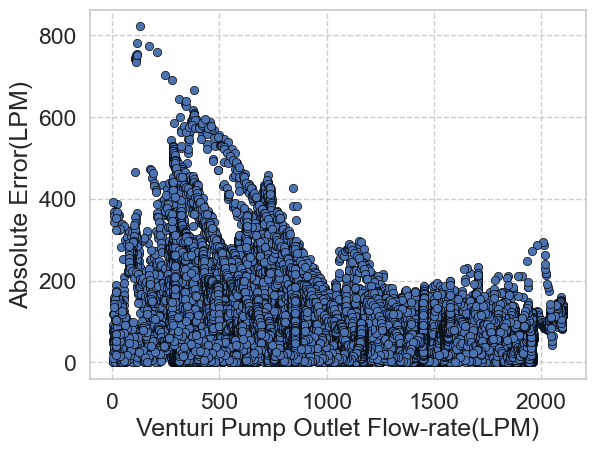

In [48]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Absolute Error(LPM)')
sns.scatterplot(x=val_target_arr, y=abs_error_list, edgecolor='black')

Text(0, 0.5, 'Absolute Error(LPM)')

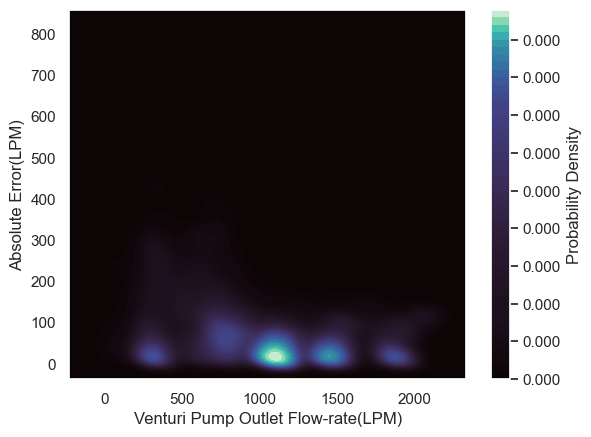

In [100]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')

sns.kdeplot(x=val_target_arr, y=abs_error_list, levels=50, thresh=0, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})

plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Absolute Error(LPM)')
#plt.ylim(0, 1000)

(0.0, 800.0)

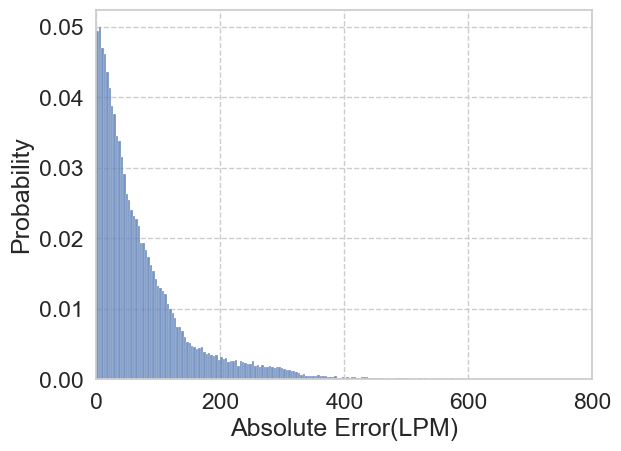

In [94]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
sns.histplot(abs_error_list, stat='probability', common_norm=False)

plt.xlabel('Absolute Error(LPM)')
plt.xlim(0, 800)

KeyboardInterrupt: 

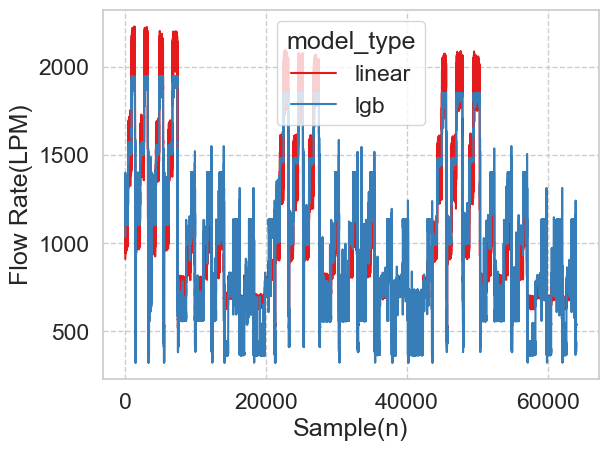

In [30]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.ylabel('Flow Rate(LPM)')
#plt.yscale('log')
plt.xlabel('Sample(n)')
sns.lineplot(data=model_result, x=np.array(model_result.index), y='estimation_flow(LPM)', hue='model_type', palette='Set1')
sns.lineplot(data=model_result, x=np.array(model_result.index), y='outlet_flowrate(lpm)')
plt.xlim(0, 100)

<AxesSubplot:xlabel='Sample(n)', ylabel='Relative Error(%)'>

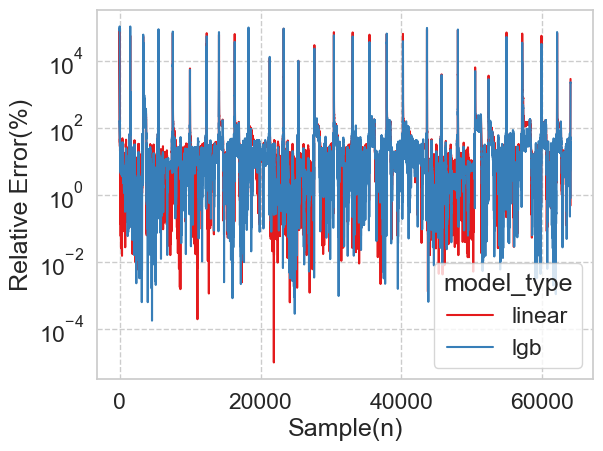

In [31]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.ylabel('Relative Error(%)')
plt.yscale('log')
plt.xlabel('Sample(n)')
sns.lineplot(data=model_result, x=np.array(model_result.index), y='relative_error(%)', hue='model_type', palette='Set1')
#plt.xlim(4000, 4500)
#plt.ylim(0, 100)

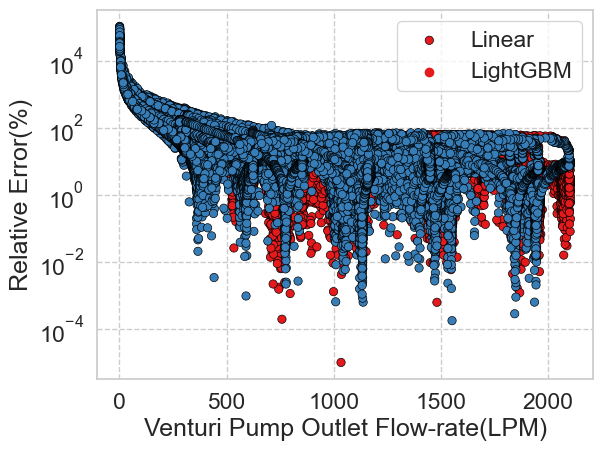

In [32]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
sns.scatterplot(data=model_result, x='outlet_flowrate(lpm)', y='relative_error(%)', hue='model_type', palette='Set1', edgecolor='black')
plt.legend(['Linear', 'LightGBM'])

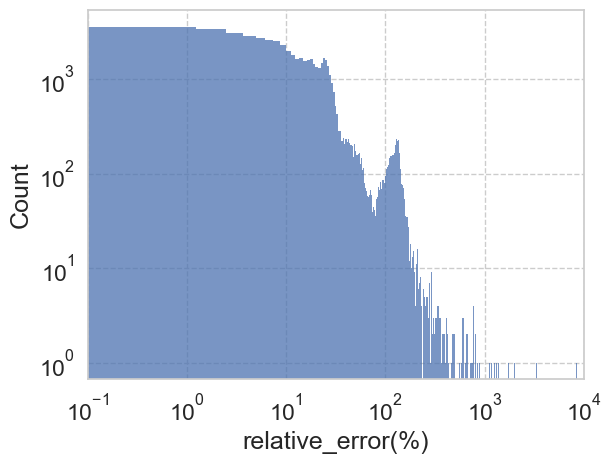

In [57]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(model_result[model_result['model_type']=='linear']['relative_error(%)'])
plt.xlim(0.1, 10000)
plt.yscale('log')
plt.xscale('log')

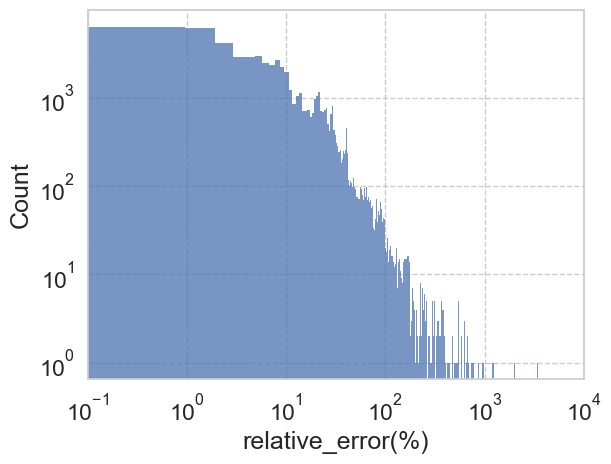

In [58]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(model_result[model_result['model_type']=='lgb']['relative_error(%)'])
plt.xlim(0.1, 10000)
plt.yscale('log')
plt.xscale('log')

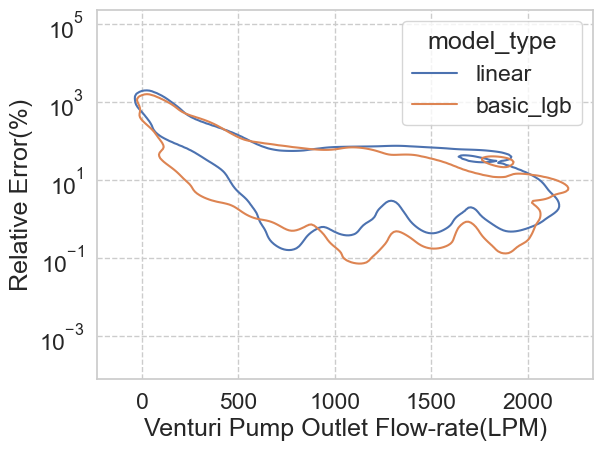

In [82]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
ked_plot = sns.kdeplot(data=model_result, x='outlet_flowrate(lpm)', y='relative_error(%)', hue='model_type', levels=2)

In [88]:
new_lgb_predout = new_lgb_model.predict(new_val_feature)
new_lgb_predout_df = pd.DataFrame(new_lgb_predout, columns=['Estimation_Flow(LPM)'])
new_lgb_rl_error = (np.abs(val_target.to_numpy()-new_lgb_predout)/np.abs(val_target.to_numpy()))*100
new_lgb_rl_error_df = pd.DataFrame(new_lgb_rl_error, columns=['Relative_Error(%)'])
new_lgb_abs_error = np.abs(val_target.to_numpy()-new_lgb_predout)
new_lgb_abs_error_df = pd.DataFrame(new_lgb_abs_error, columns=['Absolute_Error(LPM)'])

print(new_lgb_rl_error_df.mean())
print(new_lgb_abs_error_df.mean())

Relative_Error(%)    83.929067
dtype: float64
Absolute_Error(LPM)    167.862092
dtype: float64


In [89]:
flow_result = pd.concat([named_val_dataset, new_lgb_predout_df, new_lgb_abs_error_df, new_lgb_rl_error_df], axis=1)
flow_result.shape

(9305, 13)

In [90]:
flow_transient = flow_result[flow_result['venturi_pump_outlet_F(LPM)']<750]
flow_transient.reset_index(inplace=True, drop=True)
flow_transient = pd.concat([flow_transient, pd.DataFrame(['transient']*flow_transient.shape[0], columns=['phase_type'])], axis=1)

flow_steady = flow_result[flow_result['venturi_pump_outlet_F(LPM)']>750]
flow_steady.reset_index(inplace=True, drop=True)

flow_steady = pd.concat([flow_steady, pd.DataFrame(['steady']*flow_steady.shape[0], columns=['phase_type'])], axis=1)

flow_phase = pd.concat([flow_transient, flow_steady], axis=0)
flow_phase.reset_index(inplace=True, drop=True)

In [91]:
flow_phase

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
0        12.697                  -1.730                    0.037   
1        12.746                  -2.013                    0.037   
2        12.796                  -1.887                    0.038   
3        12.846                  -1.787                    0.038   
4        12.896                  -1.921                    0.036   
...         ...                     ...                      ...   
9300     67.641                  -1.829                    0.012   
9301     67.691                  -1.893                    0.010   
9302     67.740                  -1.728                    0.005   
9303     67.791                  -2.049                    0.005   
9304     67.840                  -1.629                    0.001   

      venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
0                         0.026                   -2.686   
1                         0.099                   -4.661   
2                         0.181                   -3.734   
3                         0.320                   -4.742   
4                         0.326                   -3.033   
...                         ...                      ...   
9300                      0.470                  180.603   
9301                      0.467                  179.677   
9302                      0.449                  179.361   
9303                      0.443                  179.573   
9304                      0.450                  178.389   

      venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
0                         21.153               750              45   
1                         20.029               750              45   
2                         19.895               750              45   
3                         20.218               750              45   
4                         19.805               750              45   
...                          ...               ...             ...   
9300                     910.229               900              45   
9301                     910.098               900              45   
9302                     910.804               900              45   
9303                     908.185               900              45   
9304                     901.503               900              45   

      suction_height_of_venturi(m)  run_name  Estimation_Flow(LPM)  \
0                            -0.45        31             45.168074   
1                            -0.45        31             46.290761   
2                            -0.45        31             45.168074   
3                            -0.45        31             45.168074   
4                            -0.45        31             45.161081   
...                            ...       ...                   ...   
9300                         -0.45        32            806.066998   
9301                         -0.45        32            806.066998   
9302                         -0.45        32            903.766803   
9303                         -0.45        32            809.998413   
9304                         -0.45        32            898.952836   

      Absolute_Error(LPM)  Relative_Error(%) phase_type  
0               24.015074         113.530347  transient  
1               26.261761         131.118681  transient  
2               25.273074         127.032291  transient  
3               24.950074         123.405254  transient  
4               25.356081         128.028687  transient  
...                   ...                ...        ...  
9300           104.162002          11.443494     steady  
9301           104.031002          11.430747     steady  
9302             7.037197           0.772636     steady  
9303            98.186587          10.811298     steady  
9304             2.550164           0.282879     steady  

[9305 rows x 14 columns]

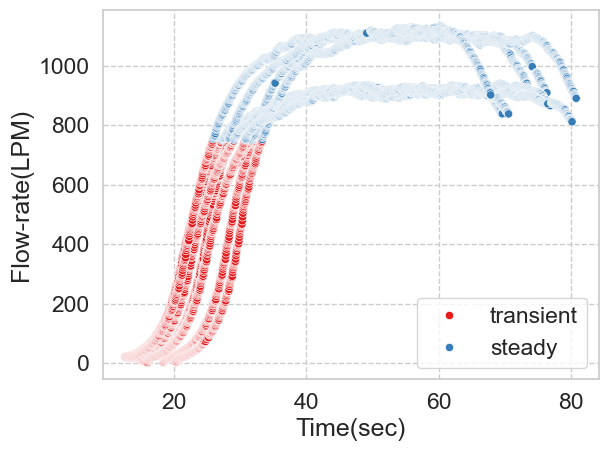

In [92]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Time(sec)')
plt.ylabel('Flow-rate(LPM)')
sns.scatterplot(data=flow_phase, x='time(sec)', y='venturi_pump_outlet_F(LPM)', hue='phase_type', palette='Set1')
plt.legend(loc='lower right')

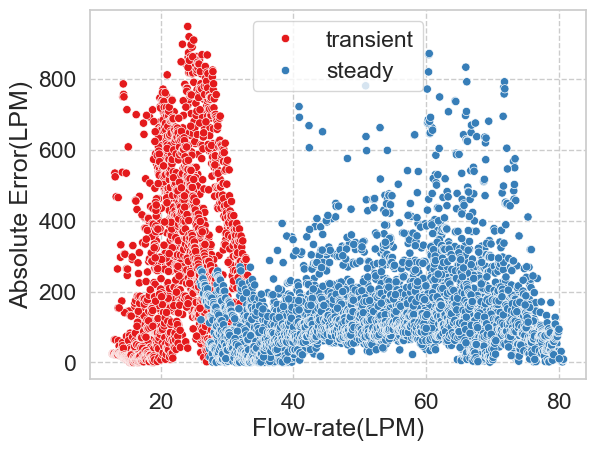

In [93]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Absolute Error(LPM)')
sns.scatterplot(data=flow_phase, x='time(sec)', y='Absolute_Error(LPM)', hue='phase_type', palette='Set1')
plt.legend(loc='upper center')

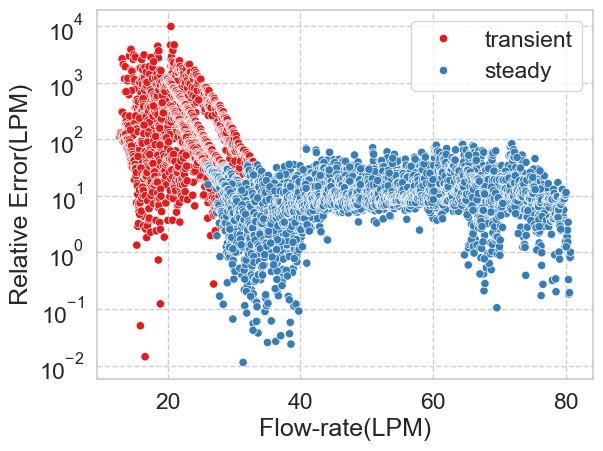

In [94]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Relative Error(LPM)')
sns.scatterplot(data=flow_phase, x='time(sec)',y='Relative_Error(%)', hue='phase_type', palette='Set1')
plt.legend(loc='upper right')

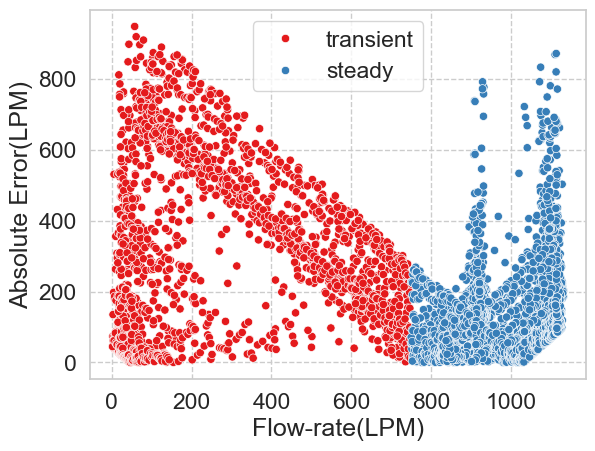

In [95]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Absolute Error(LPM)')
sns.scatterplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Absolute_Error(LPM)', hue='phase_type', palette='Set1')
plt.legend(loc='upper center')

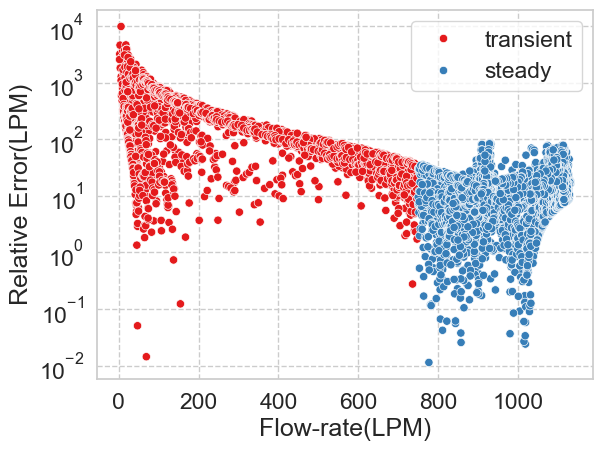

In [96]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Relative Error(LPM)')
sns.scatterplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)',y='Relative_Error(%)', hue='phase_type', palette='Set1')
plt.legend(loc='upper right')

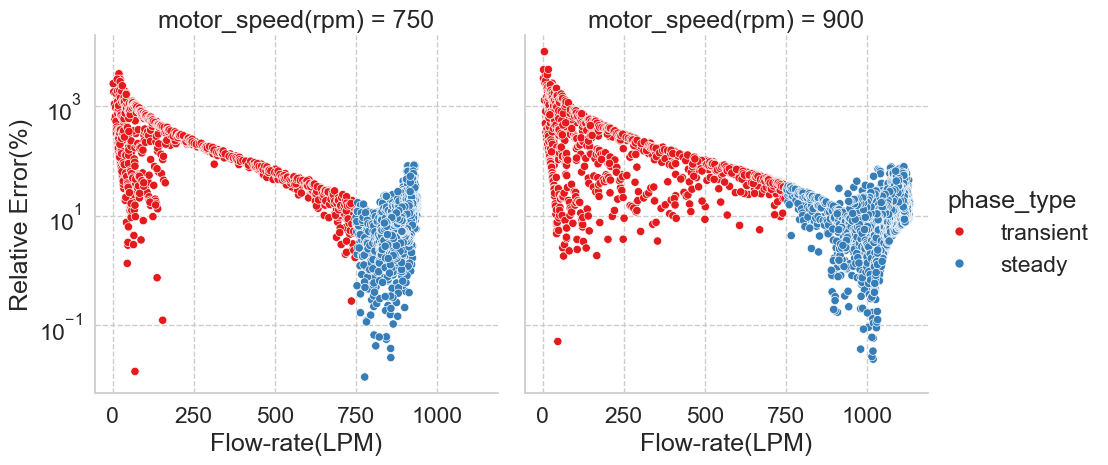

In [97]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
re = sns.relplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Relative_Error(%)', hue='phase_type', palette='Set1', col='motor_speed(rpm)')
plt.yscale('log')
re.set_ylabels('Relative Error(%)')
re.set_xlabels('Flow-rate(LPM)')

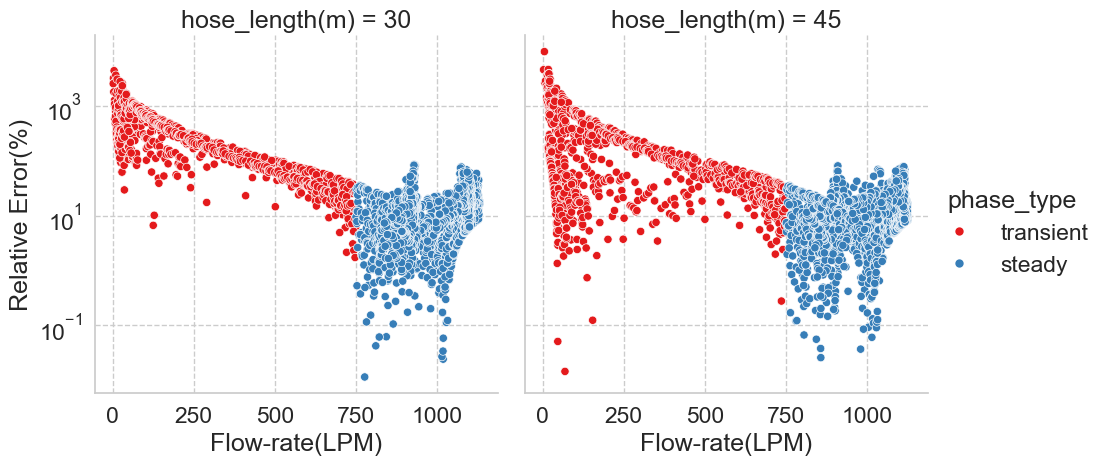

In [98]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
re = sns.relplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Relative_Error(%)', hue='phase_type', palette='Set1', col='hose_length(m)')
plt.yscale('log')
re.set_ylabels('Relative Error(%)')
re.set_xlabels('Flow-rate(LPM)')

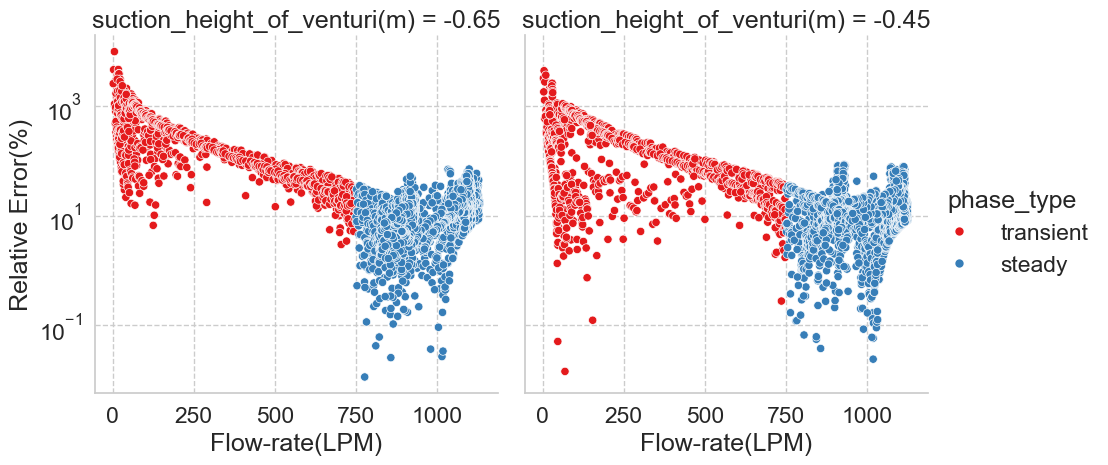

In [99]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
re = sns.relplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Relative_Error(%)', hue='phase_type', palette='Set1', col='suction_height_of_venturi(m)')
plt.yscale('log')
re.set_ylabels('Relative Error(%)')
re.set_xlabels('Flow-rate(LPM)')

In [100]:
flow_phase.describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  9305.000000             9305.000000              9305.000000   
mean     45.045720               -1.851021                 0.270931   
std      17.353969                0.096207                 0.095845   
min      12.697000               -2.195000                 0.001000   
25%      30.244000               -1.919000                 0.230000   
50%      44.845000               -1.852000                 0.240000   
75%      59.691000               -1.785000                 0.370000   
max      80.745000               -1.519000                 0.398000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count                9305.000000              9305.000000   
mean                    1.545206               157.181888   
std                     0.430442                73.795535   
min                     0.011000                -4.790000   
25%                     1.358000               103.236000   
50%                     1.378000               159.407000   
75%                     2.013000               236.329000   
max                     2.052000               246.386000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                 9305.000000       9305.000000     9305.000000   
mean                   805.678338        823.250940       37.629769   
std                    331.844553         74.983632        7.499280   
min                      1.748000        750.000000       30.000000   
25%                    772.010000        750.000000       30.000000   
50%                    911.693000        750.000000       45.000000   
75%                   1062.772000        900.000000       45.000000   
max                   1131.759000        900.000000       45.000000   

       suction_height_of_venturi(m)     run_name  Estimation_Flow(LPM)  \
count                   9305.000000  9305.000000           9305.000000   
mean                      -0.552504    28.455562            793.956199   
std                        0.099974     2.249053            225.964294   
min                       -0.650000    25.000000             45.161081   
25%                       -0.650000    27.000000            773.099811   
50%                       -0.650000    28.000000            813.430396   
75%                       -0.450000    30.000000            940.747431   
max                       -0.450000    32.000000           1032.447252   

       Absolute_Error(LPM)  Relative_Error(%)  
count          9305.000000        9305.000000  
mean            167.862092          83.929067  
std             160.350315         289.177182  
min               0.009931           0.011427  
25%              73.733271           8.584129  
50%             118.076774          13.544265  
75%             185.365739          25.436897  
max             947.957875        9824.420182

<Axes: xlabel='time(sec)', ylabel='Absolute_Error(LPM)'>

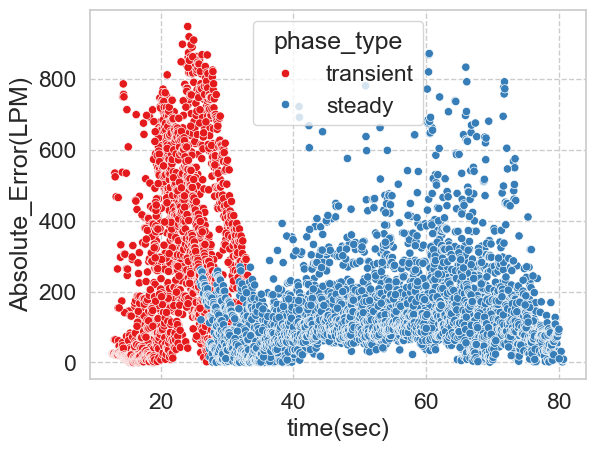

In [101]:
sns.scatterplot(data=flow_phase, x='time(sec)', y='Absolute_Error(LPM)', hue='phase_type', palette='Set1')

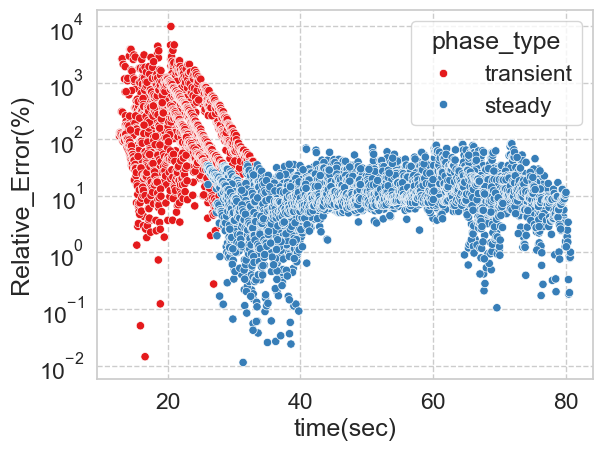

In [102]:
sns.scatterplot(data=flow_phase, x='time(sec)', y='Relative_Error(%)', hue='phase_type', palette='Set1')
plt.yscale('log')

In [103]:
a = flow_phase.copy()
a = a[a['suction_height_of_venturi(m)'] == -0.45]
print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())
print(a.shape)
print('')

161.82946045146994
67.3501187764551
(4536, 14)


In [104]:
a = flow_phase.copy()
a = a[a['phase_type'] == 'transient']
print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())
print(a.shape)
print('')

a = flow_phase.copy()
a = a[a['phase_type'] == 'steady']

print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())
print(a.shape)
print('')

301.4292741572676
307.14641275165536
(2251, 14)

125.23950458963677
12.69824086192822
(7054, 14)


In [105]:
test_vars = ['motor_speed(rpm)', 'hose_length(m)', 'suction_height_of_venturi(m)']
test_var_vals = [700, 900, 30, 50, -0.65, -0.45]

a = flow_phase.copy()
a = a[a['motor_speed(rpm)'] == 750]
a = a[a['phase_type'] == 'steady']

print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())

107.28728417974591
11.861380096374589


In [107]:
# save model
joblib.dump(linear_model, 'saved_model'+os.sep+'linear_model'+'.pkl')
print('linear model is saved!')

joblib.dump(basic_lgb_model, 'saved_model' + os.sep + 'basic_lgb_model' + '.pkl')
print('lgb model is saved!')

joblib.dump(new_lgb_model, 'saved_model' + os.sep + 'new_model' + '.pkl')
print('new lgb model is saved!')


linear model is saved!
lgb model is saved!
new lgb model is saved!


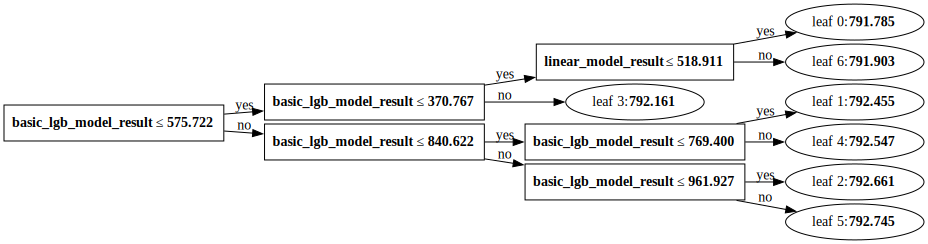

In [108]:
lgb.create_tree_digraph(new_lgb_model)